# Exercise : Computer Vision

# Face Expression Recognition 

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [ ]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os

## Load dataset 

Let's download and load the dataset and display a few random samples from it:

In [ ]:
url = 'https://drive.google.com/uc?id=1LlETXfU2Hw1yWe2iKbjA_gJ8MSB4tEVd'
output = 'FER2013.csv'
data = pd.read_csv(gdown.download(url, output, quiet=False))
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

print(f"\ntrain shape: {data_train.shape}, \nvalidation shape: {data_val.shape}, \ntest shape: {data_test.shape}")

Downloading...
From: https://drive.google.com/uc?id=1LlETXfU2Hw1yWe2iKbjA_gJ8MSB4tEVd
To: /content/FER2013.csv
301MB [00:03, 90.2MB/s]



train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
for i in data_val.index:
  print (i)

In [ ]:
def get_formatted_file(df):
    rows = []
    for i in df.index:
      row = np.array(data['pixels'][i].split(), dtype='float32').reshape(48,48)
      rows.append(row)
     
    data_X = np.array(rows)
    data_Y = np.array(df['emotion'])
    print(f'X shape: {data_X.shape}, Y shape: {data_Y.shape}')
    return data_X, data_Y

    
X_train, y_train = get_formatted_file(data_train) #training data
val_X, val_Y     = get_formatted_file(data_val) #validation data
X_test, y_test   = get_formatted_file(data_test) #test data

X shape: (28709, 48, 48), Y shape: (28709,)
X shape: (3589, 48, 48), Y shape: (3589,)
X shape: (3589, 48, 48), Y shape: (3589,)


In [ ]:
X_train = np.expand_dims(X_train, axis = -1)/255
X_test = np.expand_dims(X_test, axis = -1)/255
val_X = np.expand_dims(val_X, axis = -1)/255

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, val_X shape: {val_X.shape}')

In [ ]:
class_names = ['Angry','Digust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']

Our training set is made up of 48x48 grayscale images.
Let's visualize what some of these images and their corresponding training labels look like.

In [ ]:
plt.figure(figsize=(16,16))
random_inds = np.random.choice(20000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_train[image_ind]), cmap=plt.cm.gray)
    plt.xlabel(class_names[y_train[image_ind]])

## Convolutional Neural Network (CNN) for fashion dataset

In [ ]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_features = 64

### Define the CNN model

We will explore two new types of layers : [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Let us use the parameters shown in the network architecture above.

In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
      # Module - 1 (try more than one module of Conv2D and Maxpool layers)
      # Try adding Batchnormalisation layer
        # Define the first convolutional layer
    
        # Define the first max pooling layer
      

      # Flattening
        tf.keras.layers.Flatten(),

      # Dense layers. Try using Dropout layer

      

        # output
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through


In [ ]:
cnn_model.predict(X_train[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

### Train and test the CNN model

Let us define the loss function, optimizer, and metrics in the`compile` method.

In [ ]:
#Define the compile operation with optimizer, loss function and learning rate

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

As was the case with the fully connected model, we can train our CNN using the `fit` method via the Keras API.

In [ ]:
batch_size = 64
epoch_count = 15

# Bringing some variation to the image
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# Stops the epochs early if there is no improvement in performance
es = EarlyStopping(monitor='val_loss', 
                   patience = 10, 
                   mode = 'min', 
                   verbose = 1,
                   restore_best_weights=True)

#Train the CNN model with fit function
cnn_model.fit(data_generator.flow(X_train, y_train, batch_size), 
              batch_size=batch, 
              epochs=epoch_count, 
              callbacks = [es],
              verbose = 2,
              validation_data=(val_X, val_Y))

Let's evaluate its perforance on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [ ]:
'''Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
test_loss1, test_acc1 = cnn_model.evaluate(X_train, y_train)
print('Test accuracy - Test:', test_acc)
print('Test accuracy - Train:', test_acc1)

### Make predictions with the CNN model



In [ ]:
predictions = cnn_model.predict(X_test)

In [ ]:
predictions[0]

array([0.41973156, 0.11321825, 0.1675595 , 0.00441444, 0.17297886,
       0.02052462, 0.10157281], dtype=float32)

Prediction is : Neutral
Label is      : Neutral


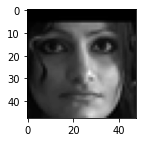

In [ ]:
'''identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
item = np.random.randint(0,1000)
prediction = np.argmax(predictions[item])

print(f'Prediction is : {class_names[prediction]}')
print(f'Label is      : {class_names[y_test[item]]}')
plt.figure (figsize= (2,2))
plt.imshow(X_test[item,:,:,0], cmap=plt.cm.gray)

In [ ]:
plt.figure(figsize=(15,15))
random_inds = np.random.choice(X_test.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.gray)
    prediction = np.argmax(predictions[image_ind])

    plt.xlabel(class_names[y_test[image_ind]]+ '/ '+class_names[prediction])